In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer, ColumnTransformer

import matplotlib.pyplot as plt

import matplotlib as mpl
#----------------------------------------
mpl.rcParams['xtick.color'] = 'tab:blue'
mpl.rcParams['ytick.color'] = 'tab:blue'
mpl.rcParams['axes.labelcolor'] = 'tab:blue'
#----------------------------------------

import seaborn as sns

In [2]:
chemin = 'data/cleaned/maintenance.csv'
maintenance_df = pd.read_csv(chemin, index_col = 0)

In [3]:
maintenance_df = maintenance_df.drop('temps_de_livraison', axis = 1)

## Les valeurs manquantes

In [4]:
rqdIndex = maintenance_df[maintenance_df['order_delivered_customer_date'].isna()].index
print(len(rqdIndex))
maintenance_df = maintenance_df.drop(rqdIndex, axis = 0)

2400


In [5]:
print(maintenance_df['order_purchase_timestamp'].dtypes, "et" ,  maintenance_df['order_delivered_customer_date'].dtypes)

object et object


In [6]:
maintenance_df['order_purchase_timestamp'] = pd.to_datetime(maintenance_df['order_purchase_timestamp'])

In [7]:
 maintenance_df['order_delivered_customer_date'] =pd.to_datetime( maintenance_df['order_delivered_customer_date'])

In [8]:
#verification que le format a bien été changé
print(maintenance_df['order_purchase_timestamp'].dtypes, "et" ,  maintenance_df['order_delivered_customer_date'].dtypes)

datetime64[ns] et datetime64[ns]


### Création de la colonne temps de livraison

In [9]:
type(maintenance_df['order_purchase_timestamp'].max())

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
maintenance_df['order_purchase_timestamp'].max()

Timestamp('2018-08-29 00:00:00')

In [11]:
maintenance_df['temps_livraison'] = (maintenance_df['order_delivered_customer_date'] - maintenance_df['order_purchase_timestamp'])

In [12]:
maintenance_df['temps_livraison'] = maintenance_df['temps_livraison'].astype('timedelta64[D]')

In [13]:
maintenance_df['temps_livraison'] = maintenance_df['temps_livraison'].astype('int')

In [14]:
maintenance_df['temps_livraison']

0          7
1         16
2          8
3          6
4         25
          ..
115604    17
115605     9
115606     5
115607     2
115608     5
Name: temps_livraison, Length: 113209, dtype: int64

In [15]:
date = maintenance_df['order_purchase_timestamp'].value_counts().index
quantité = maintenance_df['order_purchase_timestamp'].value_counts().values
df_graph = pd.DataFrame({'date' : date, 
                         'quantité' : quantité
                        })
df_graph.dtypes
df_graph = df_graph.sort_values(by = 'date')

<AxesSubplot:xlabel='date', ylabel='quantité'>

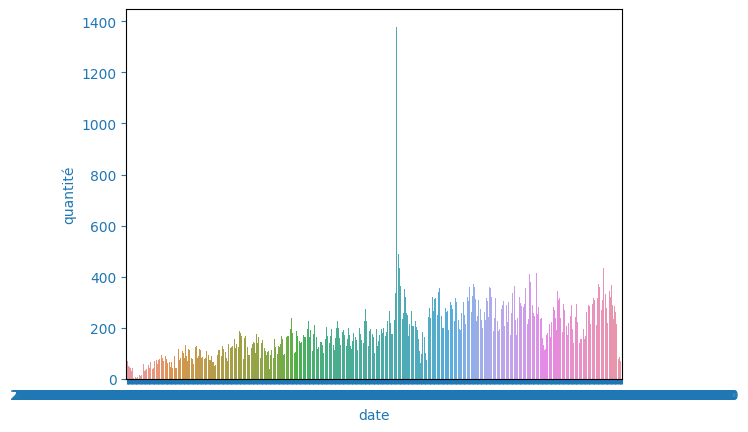

In [16]:
sns.barplot(data = df_graph, x = 'date', y = 'quantité')

In [17]:
df_graph[df_graph['quantité'] == df_graph['quantité'].max()]

,date,quantité
0,2017-11-24,1379


#### fonction ou on selectionne la date finale

In [18]:
#fonction qui va retourner une dataframe avec toutes les date < t0
def creation_df_t0(t0):
    cond = maintenance_df['order_purchase_timestamp'] <=  t0
    rqdIndex = maintenance_df[cond].index
    maintenance_t0_df = maintenance_df.loc[rqdIndex]
    return maintenance_t0_df

In [19]:
# Construction de la dataframe customers
def creation_customers_df(t0,df):
    temp_df = creation_df_t0(t0)
    print(f"Pour la date {t0}, nous avions une dataframe : {temp_df.shape}")
    customers_df = temp_df.groupby('customer_id')\
    .agg({'payment_value': 'mean', 
          'review_score': 'mean',
          'nombre_achat' : 'max',
          'Nbj_dernier_achat' : 'mean',
          'temps_livraison' : 'mean'
          })
    print(f"Nous obtenons une dataframe customers : {customers_df.shape}")
    return customers_df

In [20]:
creation_df_t0

<function __main__.creation_df_t0(t0)>

In [21]:
df = maintenance_df
t0 = '2017-11-24'
creation_customers_df(t0,df)

Pour la date 2017-11-24, nous avions une dataframe : (42611, 52)
Nous obtenons une dataframe customers : (35124, 5)


,payment_value,review_score,nombre_achat,Nbj_dernier_achat,temps_livraison
customer_id,,,,,
00012a2ce6f8dcda20d059ce98491703,114.74,1.0,1,321.0,14.0
000161a058600d5901f007fab4c27140,67.41,4.0,1,442.0,9.0
0001fd6190edaaf884bcaf3d49edf079,195.42,5.0,1,580.0,6.0
0002414f95344307404f0ace7a26f1d5,179.35,5.0,1,411.0,28.0
0004164d20a9e969af783496f3408652,71.80,1.0,1,537.0,8.0
...,...,...,...,...,...
fff25ab9d3c9ba6ad8119576f285a3d9,220.71,5.0,1,515.0,14.0
fff415b4c72e09483a25c15108c65d31,84.57,5.0,1,311.0,13.0
fff4f0c85a4d710abe06599e1ed08a42,89.70,5.0,1,555.0,6.0


In [22]:
# Test avec la date max 
df = maintenance_df
t0 = '2018-08-29 00:00:00'
creation_customers_df(t0,df)

Pour la date 2018-08-29 00:00:00, nous avions une dataframe : (113209, 52)
Nous obtenons une dataframe customers : (94486, 5)


,payment_value,review_score,nombre_achat,Nbj_dernier_achat,temps_livraison
customer_id,,,,,
00012a2ce6f8dcda20d059ce98491703,114.74,1.0,1,321.0,14.0
000161a058600d5901f007fab4c27140,67.41,4.0,1,442.0,9.0
0001fd6190edaaf884bcaf3d49edf079,195.42,5.0,1,580.0,6.0
0002414f95344307404f0ace7a26f1d5,179.35,5.0,1,411.0,28.0
000379cdec625522490c315e70c7a9fb,107.01,4.0,1,182.0,11.0
...,...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,91.91,5.0,1,198.0,4.0
fffecc9f79fd8c764f843e9951b11341,27.12,3.0,3,186.0,12.0
fffeda5b6d849fbd39689bb92087f431,63.13,4.0,1,132.0,17.0


### Constuction Kmeans avec 4 clusters

In [23]:
from sklearn.cluster import KMeans

In [24]:
KMeans.__init__

<function sklearn.cluster._kmeans.KMeans.__init__(self, n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')>

In [25]:
k_means = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, random_state = 0, algorithm = "elkan")

In [26]:
#construction d'un pipeline 
from sklearn.pipeline import Pipeline
modele = Pipeline(steps =[('preprocessing', StandardScaler()),
                          ('estimator', k_means)
                         ])

## Maintenance

In [27]:
#selection de la date t0 et cretion de la database t0
t0 = '2018-06-29 00:00:00'
df = maintenance_df
customers_t0_df = creation_customers_df(t0,df)

Pour la date 2018-06-29 00:00:00, nous avions une dataframe : (98662, 52)
Nous obtenons une dataframe customers : (81992, 5)


In [28]:
#on fit le modele
modele_t0 = modele.fit(customers_t0_df)

In [29]:
#On ajoute la colonne df dans la dataframe
customers_t0_df['labels'] = k_means.labels_
customers_t0_df['labels'].value_counts()

1    40948
0    25788
2    12556
3     2700
Name: labels, dtype: int64

In [30]:
#a t1 ou le nouveau t0 devient '2018-08-29 00:00:00'
t0 = '2018-08-29 00:00:00'
df = maintenance_df
customers_t1_df = creation_customers_df(t0,df)

Pour la date 2018-08-29 00:00:00, nous avions une dataframe : (113209, 52)
Nous obtenons une dataframe customers : (94486, 5)


### Mise en place du calcul de l'ARI

In [31]:
#label obtenu en t1 avec la methode de prédiction via le modele fit en t0
t1_predict =modele_t0.predict(customers_t1_df)
t1_predict

array([2, 0, 0, ..., 1, 1, 0], dtype=int32)

In [32]:
#label obtenu avec fit en t1
modele_t1 = k_means.fit(customers_t1_df)
modele_t1.labels_

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [33]:
#on ajoutes les deux colonnes dans la data frame customers_t1
customers_t1_df['labels_t1_predict_t0'] = t1_predict
customers_t1_df['labels_t1'] = modele_t1.labels_

In [34]:
from sklearn.metrics.cluster import adjusted_rand_score
predict = customers_t1_df['labels_t1_predict_t0']
labels = customers_t1_df['labels_t1'] 
adjusted_rand_score(labels, predict)

0.4439022709914569

## Automatisation et optimisation du calcul de l'ARI 

In [35]:
import pandas as pd

t0 = '2018-06-29 00:00:00'
t0_datetime = pd.to_datetime(t0)  # Convertir la chaîne de caractères en datetime
t1_datetime = t0_datetime + pd.Timedelta(days=5)  # Ajouter 5 jours à la date
t1 = t1_datetime.strftime('%Y-%m-%d %H:%M:%S')  # Convertir la datetime en chaîne de caractères

print(t1)  # afficher la date résultante


2018-07-04 00:00:00


In [36]:
t0_datetime = pd.to_datetime(t0)
t0_datetime

Timestamp('2018-06-29 00:00:00')

In [37]:
customers_new_t1_df = creation_customers_df(new_t1,df)

NameError: name 'new_t1' is not defined

In [ ]:
t0 = '2018-06-29 00:00:00'
tf = 

In [38]:
def new_t1 (t0,t1):
    t0 = pd.to_datetime(t0,format='%Y-%m-%d %H:%M:%S')
    t1 = pd.to_datetime(t1,format='%Y-%m-%d %H:%M:%S')
    t2 = t0 + (t1-t0)/2
    return pd.to_datetime(t2,format='%Y-%m-%d %H:%M:%S')

In [39]:
KMeans.__init__

<function sklearn.cluster._kmeans.KMeans.__init__(self, n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')>

In [40]:
t0 = '2018-06-29 00:00:00'
tf = '2018-08-29 00:00:00'
new_t1 = new_t1 (t0,t1)

In [41]:
def optimisation_ARI(t0,tf):
    #creation des listes pour enregistrer les différents score ARI
    liste_ARI_score = []
    liste_date_t0 = []
    features = ['payment_value', 'review_score', 'nombre_achat', 'Nbj_dernier_achat','temps_livraison']
    
    #construction de la dataframe en tf:
    customers_tf_df = creation_customers_df(tf,df)
    
#----------------------------------------MODELE------------------------------------------------------------------
   
    kmeans = KMeans(n_clusters = 4, init ='k-means++', algorithm  ='elkan')
    
    preprocessor = ColumnTransformer(transformers =[('scale', StandardScaler(), features)],
                                    remainder  = 'passthrough')
    
    modele = Pipeline(steps =[('preprocessor', preprocessor),
                              ('estimator', k_means)])
#----------------------------------------------------------------------------------------------------------------    
    
    
    #Entrainement modele date = tf pour obtenir les labels
    modele_tf = modele.fit(customers_tf_df[features])
    customers_tf_df['labels_t1'] = modele_tf[-1].labels_
    
    
#-------------------------------ITERATION ARI SCORE--------------------------------------------------------------    
    
    new_t0 = t0        #initialisation de new_t0
    while new_t0 < tf: #arret de la boucle
        
        #Dataframe en new_t0
        customers_t0_df = creation_customers_df(new_t0,df)
        
        #Entrainement du modele en new_t0
        modele_t0 = modele.fit(customers_t0_df[features])
        
        #labels predictions en tf avec le modele t0
        tf_predict = modele_t0.predict(customers_tf_df) 
        customers_tf_df['labels_t1_predict_t0'] = tf_predict
        
        
        #On calcul le score ARI
        predict = customers_tf_df['labels_t1_predict_t0']
        labels = customers_tf_df['labels_t1'] 
        ARI_score = adjusted_rand_score(labels, predict)
        
        
        #on ajoute le date et le score dans les listes corespondantes
        liste_ARI_score.append(ARI_score)
        liste_date_t0.append(new_t0)
        
        #on fixe une nouvelle date
        old_t0 = new_t0
        old_t0_datetime = pd.to_datetime(old_t0)  # Convertir la chaîne de caractères en datetime
        new_t0_datetime = old_t0_datetime + pd.Timedelta(days=7)  # Ajouter 5 jours à la date
        new_t0 = new_t0_datetime.strftime('%Y-%m-%d %H:%M:%S')  # Convertir la datetime en chaîne de caractères
        
    return liste_ARI_score, liste_date_t0

In [42]:
t0 = '2017-08-29 00:00:00'
tf = '2018-08-29 00:00:00'
liste_ARI_score, liste_date_t0 = optimisation_ARI(t0,tf)

Pour la date 2018-08-29 00:00:00, nous avions une dataframe : (113209, 52)
Nous obtenons une dataframe customers : (94486, 5)
Pour la date 2017-08-29 00:00:00, nous avions une dataframe : (25908, 52)
Nous obtenons une dataframe customers : (21383, 5)
Pour la date 2017-09-05 00:00:00, nous avions une dataframe : (27092, 52)
Nous obtenons une dataframe customers : (22350, 5)
Pour la date 2017-09-12 00:00:00, nous avions une dataframe : (28216, 52)
Nous obtenons une dataframe customers : (23286, 5)
Pour la date 2017-09-19 00:00:00, nous avions une dataframe : (29469, 52)
Nous obtenons une dataframe customers : (24336, 5)
Pour la date 2017-09-26 00:00:00, nous avions une dataframe : (30612, 52)
Nous obtenons une dataframe customers : (25258, 5)
Pour la date 2017-10-03 00:00:00, nous avions une dataframe : (31745, 52)
Nous obtenons une dataframe customers : (26203, 5)
Pour la date 2017-10-10 00:00:00, nous avions une dataframe : (32927, 52)
Nous obtenons une dataframe customers : (27183, 5)

In [43]:
#on change le format de la date dans la liste
liste_date_t0 = [x.split(' ')[0] for x in liste_date_t0]

In [52]:
Ari_score_df = pd.DataFrame({'Ari_score': liste_ARI_score,'date' : liste_date_t0 })
Ari_score_df.sort_values(by ='Ari_score', ascending = False)

,Ari_score,date
52,0.999782,2018-08-28
51,0.990651,2018-08-21
50,0.963611,2018-08-14
49,0.923145,2018-08-07
48,0.779281,2018-07-31
47,0.755604,2018-07-24
46,0.734018,2018-07-17
45,0.725307,2018-07-10
44,0.717745,2018-07-03
43,0.707427,2018-06-26


/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


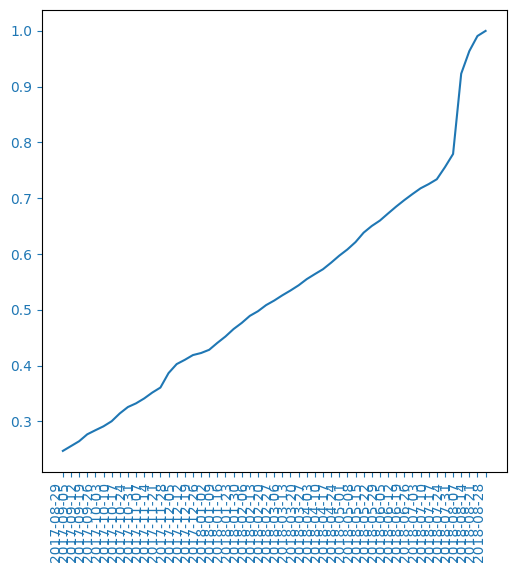

In [45]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
plt.plot(liste_date_t0, liste_ARI_score)
ax.set_xticklabels(liste_date_t0, rotation = 90, ha ='right')
plt.show()

In [ ]:
pd.to